# Visualizing internal tides 

In [1]:
import matplotlib.pyplot as plt 
import matplotlib
#matplotlib.use('Agg')
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import numpy as np

from joblib import Parallel
from joblib import delayed as jb_delayed

In [ ]:
! export  HDF5_USE_FILE_LOCKING=FALSE

## 1. - Data import 

In [2]:
ds = xr.open_mfdataset("/bettik/bellemva/MITgcm/MITgcm_it/by_mode/MITgcm_it_2012060*.nc",combine='nested',concat_dim="time",parallel=True)
ds = ds.load()

## 2. - Plot 

In [ ]:
def create_plot(date,ssh_it1,ssh_it2,ssh_it3):

    fig, ax = plt.subplots(1,3,figsize=(13,6),subplot_kw={"projection": ccrs.PlateCarree(central_longitude=195.)},dpi=300)

    for i,title,ssh,v_ex in zip(range (3),
                    ["Mode 1","Mode 2","Mode3"],
                    [ssh_it1,ssh_it2,ssh_it3],
                    [10,4,2]):
        ax[i].set_extent([185, 205,15, 35],crs=ccrs.PlateCarree())

        plot = ax[i].pcolormesh(ds.longitude.values, 
                ds.latitude.values, 
                100*ssh,
                vmin=-v_ex,vmax=v_ex,
                cmap="RdBu",
                transform=ccrs.PlateCarree()
                )

        ax[i].add_feature(cfeature.LAND,color="lightgrey",zorder=1)
        #ax[i].add_feature(cfeature.OCEAN,color="black",zorder=0)
        ax[i].coastlines(lw=0.5)

        gridlines = ax[i].gridlines(
            alpha=0.3,
            color="black",
            draw_labels=True,
            xlocs=np.arange(-175,-155,5),
            ylocs=np.arange(20,50,5),
            # xformatter=cartopy.mpl.ticker.LongitudeFormatter(zero_direction_label=True,),
        )
        gridlines.right_labels = False
        gridlines.top_labels  = False
        gridlines.xlabel_style = {'size': 8}
        gridlines.ylabel_style = {'size': 8}
        ax[i].set_aspect("equal")

        cbar = plt.colorbar(plot,ax=ax[i],location="bottom",shrink=0.7)
        cbar.set_label("cm",labelpad=-35)

        ax[i].set_title(title,size=18)

        fig.suptitle("Internal Tide : "+date.astype('datetime64[D]').astype('str'),size=24)

        plt.savefig("/home/bellemva/CCS/data/filter_tool/extract_modes/frames/modes"+date.astype('datetime64[h]').astype("str")+".png")


In [ ]:
Parallel(n_jobs=12,backend='multiprocessing')(jb_delayed(create_plot)(ds.time[i].values,
                                                                      ds.ssh_it1[i].values,
                                                                      ds.ssh_it2[i].values,
                                                                      ds.ssh_it3[i].values) for i in range(ds.dims["time"]))

## 3. - Analysing plots (and anomalys)

In [3]:
ssh_it1 = ds.ssh_it1.values

In [12]:
array_diff = np.nansum((ssh_it1[:-1]-ssh_it1[1:])**2,axis=(1,2))

<BarContainer object of 14 artists>

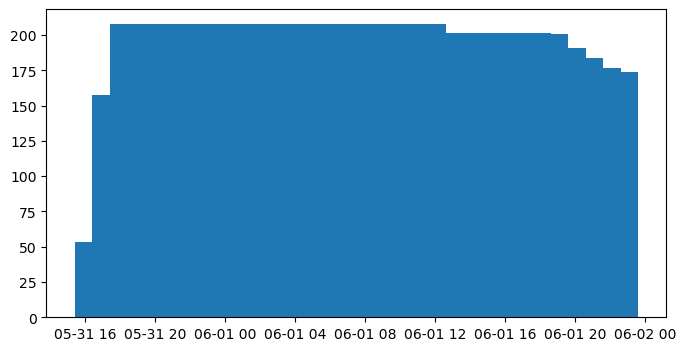

In [13]:
fig,ax = plt.subplots(figsize=(8,4))
ax.bar(ds.time[1:15].values,array_diff[:14])


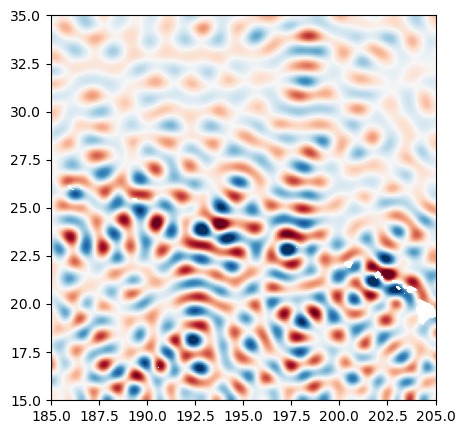

In [28]:
ssh = ssh_it1[10]-ssh_it1[9]
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(ds.longitude.values,ds.latitude.values,ssh,vmin=-0.05,vmax=0.05,cmap="RdBu")
ax.set_aspect("equal")


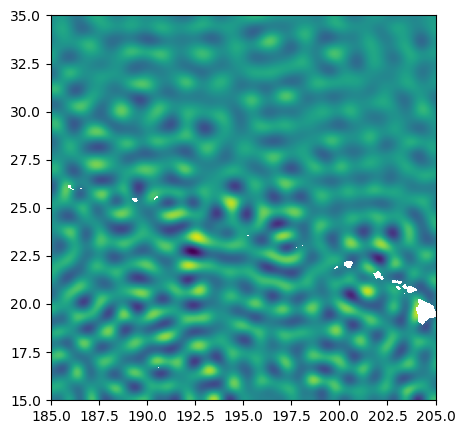

In [26]:
ssh = ssh_it1[3]
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(ds.longitude.values,ds.latitude.values,ssh,vmin=-0.05,vmax=0.05)
ax.set_aspect("equal")


In [29]:
path_config = '/home/bellemva/CCS/Configs/config_2022a_4DVAR_QG_SWOT.py'

In [34]:
import sys
sys.path.append('/home/bellemva/MASSH/mapping')
from src import exp
config = exp.Exp(path_config)

name_experiment: 2022a_4DVAR_QG_SWOT
saveoutputs: True
name_exp_save: 2022a_4DVAR_QG_SWOT
path_save: ../outputs/2022a_4DVAR_QG_SWOT
tmp_DA_path: ../scratch/2022a_4DVAR_QG_SWOT
init_date: 2012-02-01 00:00:00
final_date: 2012-04-01 00:00:00
assimilation_time_step: 1:00:00
saveoutput_time_step: 12:00:00
flag_plot: 1
write_obs: True
path_obs: ../obs/2022a_4DVAR_QG_SWOT
name_lon: lon
name_lat: lat
name_time: time
plot_time_step: 1 day, 0:00:00
time_obs_min: None
time_obs_max: None
compute_obs: False



In [44]:
ds.latitude

<xarray.DataArray 'latitude' (latitude: 961)>
array([15.      , 15.020833, 15.041667, ..., 34.958332, 34.979168, 35.      ],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 15.0 15.02 15.04 15.06 ... 34.96 34.98 35.0

In [55]:
ssh_igw = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120601.nc").ssh_igw.load()
ssh_igw = ssh_igw.sel(longitude = slice(185.,205.),latitude = slice(15.,35.),drop=True)

Text(0.5, 1.0, 'IT : 2012-06-01T03')

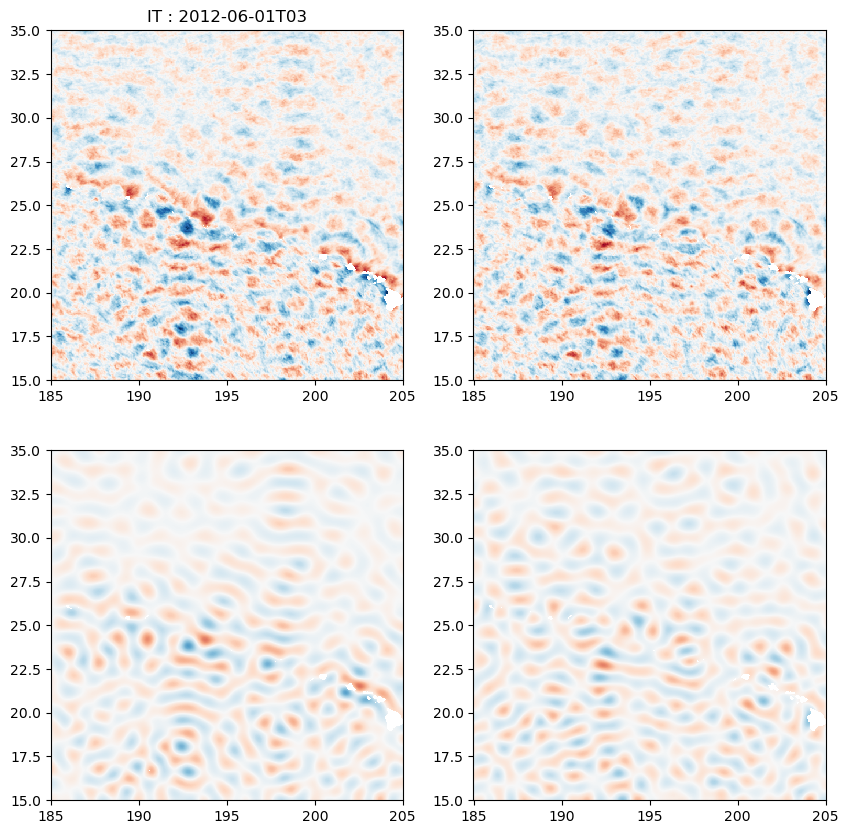

In [60]:

fig,ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].pcolormesh(ds.longitude.values,ds.latitude.values,ssh_igw[2],vmin=-0.10,vmax=0.10,cmap="RdBu")
ax[0,0].set_title("IGW : 2012-06-01T02")
ax[0,1].pcolormesh(ds.longitude.values,ds.latitude.values,ssh_igw[3],vmin=-0.10,vmax=0.10,cmap="RdBu")
ax[0,0].set_title("IGW : 2012-06-01T03")
ax[1,0].pcolormesh(ds.longitude.values,ds.latitude.values,ssh_it1[2],vmin=-0.10,vmax=0.10,cmap="RdBu")
ax[0,0].set_title("IT : 2012-06-01T02")
ax[1,1].pcolormesh(ds.longitude.values,ds.latitude.values,ssh_it1[3],vmin=-0.10,vmax=0.10,cmap="RdBu")
ax[0,0].set_title("IT : 2012-06-01T03")
